In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
import random

In [14]:
k, b = random.random(), random.random()

In [15]:
k, b

(0.3320014548127125, 0.5399141916477559)

In [16]:
NUM = 1000

In [53]:
X = [float(x) for x in range(NUM)]

In [54]:
Y = [k*x + b + 1.2* random.random() for x in X]

In [55]:
import matplotlib.pyplot as plt

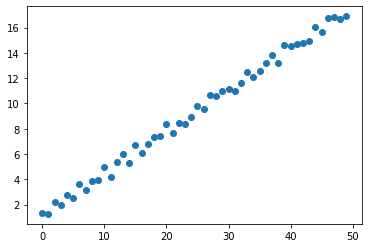

In [56]:
plt.scatter(X[:50],Y[:50])
plt.show()

In [80]:
from torch import nn
import torch

In [81]:
import torch.nn.functional as F

In [125]:
train_x, train_y = torch.tensor(X[:800]).unsqueeze(-1),torch.tensor(Y[:800])

In [126]:
valid_x, valid_y = torch.tensor(X[800:]).unsqueeze(-1),torch.tensor(Y[800:])

In [234]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 50)
        self.out = nn.Linear(50, 1)
    
    def forward(self, x):
        return self.out(F.relu(self.lin(x)))

In [324]:
model = Model0()

In [319]:
bs=64

xb = train_x[0:bs]
preds = model(xb)
xb[0], preds[0], preds.shape

(tensor([0.]), tensor([0.6857], grad_fn=<SelectBackward>), torch.Size([64, 1]))

In [320]:
yb = train_y[:bs]

In [439]:
def rmse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean().sqrt()

In [440]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(169.0848, grad_fn=<SqrtBackward>)

In [441]:
def fit(model, X, Y, loss_func=rmse,epochs=10, bs=64, lr=0.5, metrics=None):
    for epoch in range(epochs):
        for i in range((len(X)-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = X[start_i:end_i]
            yb = Y[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
                
            loss.backward()
            with torch.no_grad():
                for l in [model.lin, model.out]:
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
        with torch.no_grad():
            print('epoch: ', epoch, 'train-loss: ', loss_func(model(X), Y))

In [327]:
model = Model0()
fit(model, train_x, train_y, lr=0.001, epochs=10)

epoch:  0 train-loss:  tensor(324.2517)
epoch:  1 train-loss:  tensor(215.3129)
epoch:  2 train-loss:  tensor(133.9086)
epoch:  3 train-loss:  tensor(101.0341)
epoch:  4 train-loss:  tensor(174.8167)
epoch:  5 train-loss:  tensor(26.9521)
epoch:  6 train-loss:  tensor(130.6346)
epoch:  7 train-loss:  tensor(101.0560)
epoch:  8 train-loss:  tensor(174.6272)
epoch:  9 train-loss:  tensor(26.8656)


In [328]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(1.1559, grad_fn=<SqrtBackward>)

In [251]:
for name,l in model.named_children(): print(f"{name}: {l}")

lin: Linear(in_features=1, out_features=50, bias=True)
out: Linear(in_features=50, out_features=1, bias=True)


In [329]:
from torch import optim

In [447]:
def fit(model, X, Y, loss_func=rmse,epochs=10, bs=64, opt=None, metrics=None):
    for epoch in range(epochs):
        model.train()
        for i in range((len(X)-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = X[start_i:end_i]
            yb = Y[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
                
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            print('epoch: ', epoch, 'train-loss: ', loss_func(model(X), Y))

In [448]:
model = Model0()
fit(model, train_x, train_y, epochs=11, opt=optim.SGD(model.parameters(), lr=0.001))

epoch:  0 train-loss:  tensor(153.8656)
epoch:  1 train-loss:  tensor(151.5849)
epoch:  2 train-loss:  tensor(147.4595)
epoch:  3 train-loss:  tensor(140.3367)
epoch:  4 train-loss:  tensor(126.8914)
epoch:  5 train-loss:  tensor(99.6299)
epoch:  6 train-loss:  tensor(48.8456)
epoch:  7 train-loss:  tensor(57.3856)
epoch:  8 train-loss:  tensor(90.9178)
epoch:  9 train-loss:  tensor(70.8440)
epoch:  10 train-loss:  tensor(48.3922)


In [387]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(6.4786, grad_fn=<SqrtBackward>)

In [388]:
model(train_x[0])

tensor([11.3673], grad_fn=<AddBackward0>)

## Normalize

In [390]:
def normalize(x, m, s): return (x-m)/s

In [391]:
train_mean,train_std = train_x.mean(),train_x.std()
train_mean,train_std

(tensor(-1.3411e-09), tensor(1.))

In [392]:
train_x = normalize(train_x, train_mean, train_std)
valid_x = normalize(valid_x, train_mean, train_std)

In [393]:
train_x.mean(),train_x.std()

(tensor(-1.3411e-09), tensor(1.))

In [395]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.SGD(model.parameters(), lr=0.001))

epoch:  0 train-loss:  tensor(153.2147)
epoch:  1 train-loss:  tensor(150.9793)
epoch:  2 train-loss:  tensor(146.8963)
epoch:  3 train-loss:  tensor(139.6177)
epoch:  4 train-loss:  tensor(125.4473)
epoch:  5 train-loss:  tensor(96.9875)
epoch:  6 train-loss:  tensor(47.8640)
epoch:  7 train-loss:  tensor(70.1603)
epoch:  8 train-loss:  tensor(106.6311)
epoch:  9 train-loss:  tensor(88.4668)


## Adam

In [405]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01))

epoch:  0 train-loss:  tensor(152.9406)
epoch:  1 train-loss:  tensor(149.7217)
epoch:  2 train-loss:  tensor(144.4590)
epoch:  3 train-loss:  tensor(135.6977)
epoch:  4 train-loss:  tensor(122.5553)
epoch:  5 train-loss:  tensor(104.5215)
epoch:  6 train-loss:  tensor(81.1717)
epoch:  7 train-loss:  tensor(52.6497)
epoch:  8 train-loss:  tensor(24.0992)
epoch:  9 train-loss:  tensor(37.4898)


## Regularization

In [468]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01, weight_decay=0.5))

epoch:  0 train-loss:  tensor(152.9894)
epoch:  1 train-loss:  tensor(151.4410)
epoch:  2 train-loss:  tensor(149.6250)
epoch:  3 train-loss:  tensor(146.6585)
epoch:  4 train-loss:  tensor(141.2507)
epoch:  5 train-loss:  tensor(131.6140)
epoch:  6 train-loss:  tensor(116.8729)
epoch:  7 train-loss:  tensor(96.5018)
epoch:  8 train-loss:  tensor(69.6085)
epoch:  9 train-loss:  tensor(35.9067)


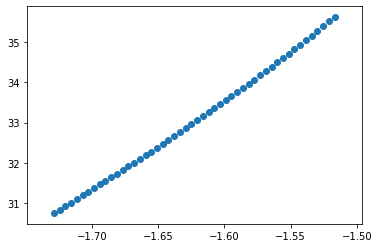

In [469]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()

## Batch-size - speed

In [417]:
model = Model0()

In [419]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=1)

epoch:  0 train-loss:  tensor(511.2061)
epoch:  1 train-loss:  tensor(247.3071)
epoch:  2 train-loss:  tensor(535.6971)
epoch:  3 train-loss:  tensor(409.9441)
epoch:  4 train-loss:  tensor(87.8636)
epoch:  5 train-loss:  tensor(79.0429)
epoch:  6 train-loss:  tensor(1067.0833)
epoch:  7 train-loss:  tensor(274.5234)
epoch:  8 train-loss:  tensor(302.4339)
epoch:  9 train-loss:  tensor(919.6824)
CPU times: user 7.81 s, sys: 290 ms, total: 8.1 s
Wall time: 5.52 s


In [420]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=64)

epoch:  0 train-loss:  tensor(904.4087)
epoch:  1 train-loss:  tensor(889.1667)
epoch:  2 train-loss:  tensor(873.9164)
epoch:  3 train-loss:  tensor(858.6313)
epoch:  4 train-loss:  tensor(843.3091)
epoch:  5 train-loss:  tensor(827.9493)
epoch:  6 train-loss:  tensor(812.5560)
epoch:  7 train-loss:  tensor(797.1339)
epoch:  8 train-loss:  tensor(781.6869)
epoch:  9 train-loss:  tensor(766.2234)
CPU times: user 385 ms, sys: 18.1 ms, total: 403 ms
Wall time: 109 ms


In [421]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=1000)

epoch:  0 train-loss:  tensor(765.1339)
epoch:  1 train-loss:  tensor(764.0444)
epoch:  2 train-loss:  tensor(762.9556)
epoch:  3 train-loss:  tensor(761.8672)
epoch:  4 train-loss:  tensor(760.7792)
epoch:  5 train-loss:  tensor(759.6917)
epoch:  6 train-loss:  tensor(758.6044)
epoch:  7 train-loss:  tensor(757.5176)
epoch:  8 train-loss:  tensor(756.4315)
epoch:  9 train-loss:  tensor(755.3459)
CPU times: user 161 ms, sys: 23 ms, total: 184 ms
Wall time: 37.3 ms


## Batchnorm

In [450]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 50)
        self.out = nn.Linear(50, 1)
        self.bn = nn.BatchNorm1d(50)
    
    def forward(self, x):
        return self.out(self.bn(F.relu(self.lin(x))))

In [451]:
model = Model1()
rmse(model(train_x[0:bs]), yb[:bs])

tensor(13.2920, grad_fn=<SqrtBackward>)

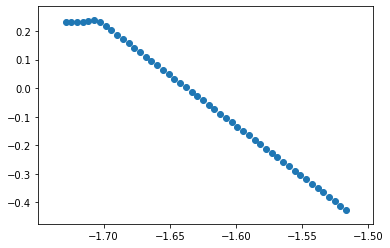

In [452]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()

In [466]:
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01))
rmse(model(train_x[0:bs]), yb[:bs])

epoch:  0 train-loss:  tensor(669.0980)
epoch:  1 train-loss:  tensor(877.4543)
epoch:  2 train-loss:  tensor(1083.0463)
epoch:  3 train-loss:  tensor(1250.9193)
epoch:  4 train-loss:  tensor(1351.8588)
epoch:  5 train-loss:  tensor(1362.3995)
epoch:  6 train-loss:  tensor(1269.4364)
epoch:  7 train-loss:  tensor(1089.6935)
epoch:  8 train-loss:  tensor(858.9086)
epoch:  9 train-loss:  tensor(618.4482)


tensor(1289.2028, grad_fn=<SqrtBackward>)

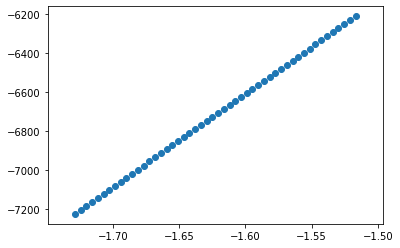

In [461]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()